## Predict air quality in Madrid with Fedot.Industrial

Dataset published on Kaggle Its input data consists in measurements of the **level of sulphur dioxide, carbon monoxide and nitric oxide**. Time series correspond to hourly values measured during a week. The target value is the **weekly averaged PM10**. The final dataset includes 6922 3-dimensional time series with a length of 168. The training dataset is composed of randomly selected 70% of the samples, whereas the remaining 30% forms the testing dataset.
Link to the dataset - https://www.kaggle.com/datasets/decide-soluciones/air-quality-madrid

In [1]:
import pandas as pd
from fedot_ind.tools.loader import DataLoader

2025-01-28 14:36:39,569 - PyTorch version 2.2.2 available.


In [2]:
from fedot_ind.core.repository.config_repository import DEFAULT_COMPUTE_CONFIG, DEFAULT_REG_AUTOML_CONFIG, DEFAULT_AUTOML_LEARNING_CONFIG

DATASET_NAME = 'MadridPM10Quality-no-missing'

API_CONFIG = {'industrial_config': {'problem': 'regression'},
              'automl_config': DEFAULT_REG_AUTOML_CONFIG,
              'learning_config': {'learning_strategy': 'from_scratch',
                                  'learning_strategy_params': DEFAULT_AUTOML_LEARNING_CONFIG,
                                  'optimisation_loss': {'quality_loss': 'rmse'}},
              'compute_config': DEFAULT_COMPUTE_CONFIG}
METRIC_NAMES = ('r2', 'rmse', 'mae')

Now we must download the dataset. It could be done by using `DataLoader` class. This class firstly tries to read the data from local project folder `folder` and then if it is not possible, it downloads the data from the UCR/UEA archive. The data will be saved in the `folder` directory.

In [3]:
from fedot_ind.tools.serialisation.path_lib import EXAMPLES_DATA_PATH

train_data, test_data = DataLoader(dataset_name=DATASET_NAME,
                                   folder=EXAMPLES_DATA_PATH).load_data()

2025-01-28 14:36:40,198 - Reading data from /Users/lopatenko/Desktop/dev/Fedot.Industrial/examples/data/MadridPM10Quality-no-missing
2025-01-28 14:36:43,030 - Data read successfully from local folder


Lets check our data.

In [4]:
features = train_data[0]
features.shape

(4845, 3, 168)

Lets visualise our predictors.

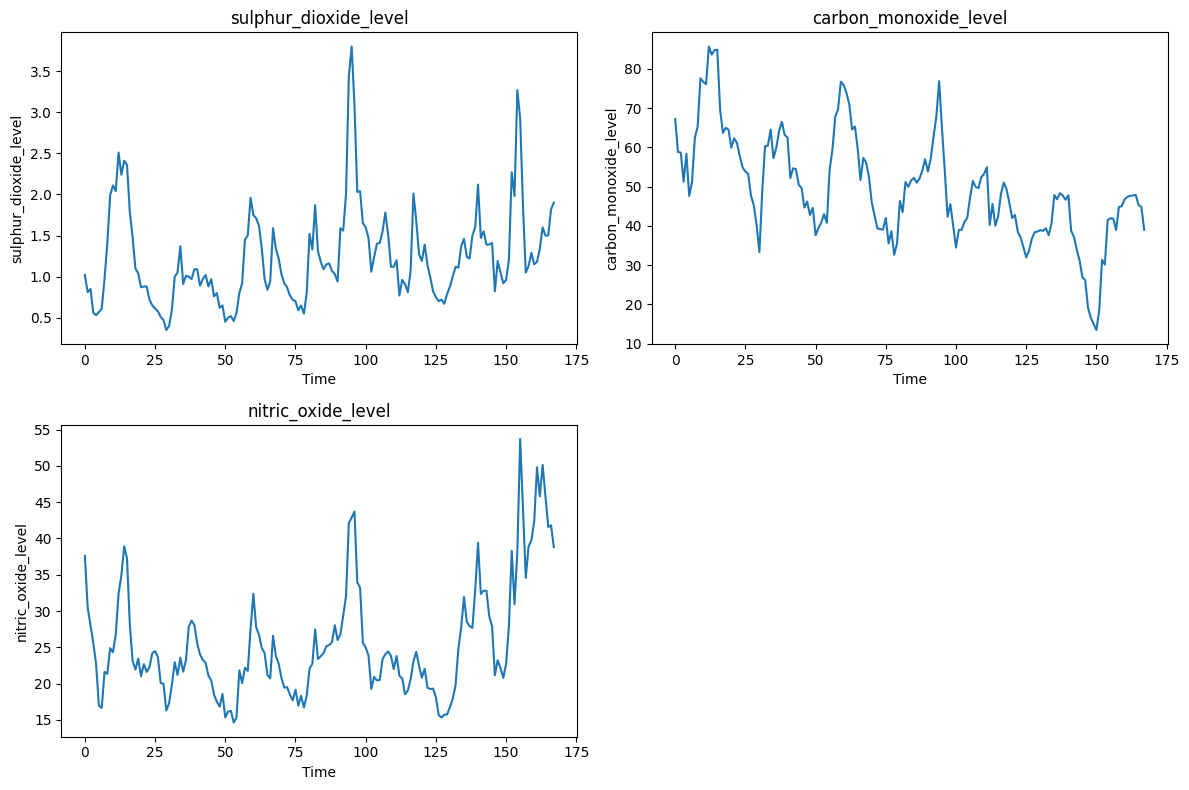

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

feature_names = ['sulphur_dioxide_level', 'carbon_monoxide_level', 'nitric_oxide_level']
n_features = len(feature_names)
ncols = 2
nrows = (n_features + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows))
axes = axes.flatten()

for i in range(n_features):
    feature_data = features[1, i, :]
    df = pd.DataFrame(feature_data, columns=[feature_names[i]])
    ax = axes[i]
    df.plot(ax=ax, title=feature_names[i], legend=False)
    ax.set_xlabel('Time')
    ax.set_ylabel(feature_names[i])

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

In [ ]:
from fedot_ind.core.architecture.pipelines.abstract_pipeline import ApiTemplate

dataset_dict = dict(train_data=train_data, test_data=test_data)
result_dict = ApiTemplate(api_config=API_CONFIG,
                          metric_list=METRIC_NAMES).eval(dataset=dataset_dict,
                                                         finetune=False)

2025-01-28 14:24:12,428 - --------------------------------------------------
2025-01-28 14:24:12,428 - Initialising Industrial Repository
2025-01-28 14:24:12,429 - -------------------------------------------------
2025-01-28 14:24:12,429 - Initialising Industrial Evolutionary Optimisation params
2025-01-28 14:24:12,444 - --------------------------------------------------
2025-01-28 14:24:12,445 - Initialising Dask Server
Creating Dask Server
2025-01-28 14:24:12,458 - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2025-01-28 14:24:12,460 - State start
2025-01-28 14:24:12,463 -   Scheduler at: inproc://192.168.1.71/52040/1
2025-01-28 14:24:12,463 -   dashboard at:  http://192.168.1.71:8787/status
2025-01-28 14:24:12,464 - Registering Worker plugin shuffle
2025-01-28 14:24:12,468 -       Start worker at: inproc://192.168.1.71/52040/4
2025-01-28 14:24:12,468 -          Listening to:         inproc192.168.1.71
2025-

At the end of the experiment we can obtain the desired metric values using `calculate_regression_metric` method. Now there are five available metrics for classification task:
- `explained_variance_score`
- `max_error`
- `mean_absolute_error`
- `mean_squared_error`
- `d2_absolute_error_score`.
- `median_absolute_error`
- `r2_score`

In [ ]:
result_dict['metrics']

## Could it be done better? Tuning approach

In [9]:
from fedot_ind.core.architecture.pipelines.abstract_pipeline import ApiTemplate

INITIAL_ASSUMPTION = {0: ['quantile_extractor', 'treg']}

dataset_dict = dict(train_data=train_data, test_data=test_data)
finetuned_result_dict = ApiTemplate(api_config=API_CONFIG,
                                    metric_list=METRIC_NAMES).eval(dataset=dataset_dict,
                                                                   initial_assumption=INITIAL_ASSUMPTION,
                                                                   finetune=True)

2025-01-28 14:37:22,211 - --------------------------------------------------
2025-01-28 14:37:22,212 - Initialising Industrial Repository
2025-01-28 14:37:22,213 - -------------------------------------------------
2025-01-28 14:37:22,213 - Initialising Industrial Evolutionary Optimisation params
2025-01-28 14:37:22,237 - DataSourceSplitter - Stratificated splitting of data is disabled.
2025-01-28 14:37:22,238 - DataSourceSplitter - Hold out validation is applied.
2025-01-28 14:37:22,270 - OptunaTuner - Hyperparameters optimization start: estimation of metric for initial graph
2025-01-28 14:37:22,273 - Trying to load features from cache
2025-01-28 14:37:22,275 - Cache not found


compute_feature_extraction_with_Statistical Class for TS representation:   0%|          | 0/484 [00:00<?, ?it/…

2025-01-28 14:37:29,077 - Caching features
2025-01-28 14:37:29,189 - Trying to load features from cache
2025-01-28 14:37:29,190 - Cache not found


compute_feature_extraction_with_Statistical Class for TS representation:   0%|          | 0/4361 [00:00<?, ?it…

2025-01-28 14:38:30,514 - Caching features
2025-01-28 14:38:30,545 - OptunaTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [treg, quantile_extractor]}
treg - {}
quantile_extractor - {} 
Initial metric: [10.139]


[I 2025-01-28 14:38:30,545] A new study created in memory with name: no-name-42fa60c9-60f4-489e-88c0-6d37c557fc82


2025-01-28 14:38:30,578 - Trying to load features from cache
2025-01-28 14:38:30,581 - Trying to load features from cache
2025-01-28 14:38:30,581 - Trying to load features from cache
2025-01-28 14:38:30,582 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type are loaded from cache in 0.00241 sec
Features of basis of <class 'numpy.ndarray'> type are loaded from cache in 0.0015 sec
2025-01-28 14:38:30,584 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type are loaded from cache in 0.00105 sec
2025-01-28 14:38:30,585 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type are loaded from cache in 0.00804 sec2025-01-28 14:38:30,588 - Trying to load features from cache

Features of basis of <class 'numpy.ndarray'> type are loaded from cache in 0.01665 sec
Features of basis of <class 'numpy.ndarray'> type are loaded from cache in 0.04081 sec
2025-01-28 14:38:30,590 - Trying to load features fr

compute_feature_extraction_with_Statistical Class for TS representation:   0%|          | 0/4361 [00:00<?, ?it…

2025-01-28 14:38:31,358 - Trying to load features from cache
2025-01-28 14:38:31,663 - Trying to load features from cache
2025-01-28 14:38:31,666 - Trying to load features from cache
2025-01-28 14:38:31,668 - Cache not found


compute_feature_extraction_with_Statistical Class for TS representation:   0%|          | 0/4361 [00:00<?, ?it…

2025-01-28 14:38:31,716 - Trying to load features from cache
2025-01-28 14:38:31,752 - Cache not found
2025-01-28 14:38:31,913 - Trying to load features from cache
2025-01-28 14:38:31,933 - Cache not found


compute_feature_extraction_with_Statistical Class for TS representation:   0%|          | 0/4361 [00:00<?, ?it…

compute_feature_extraction_with_Statistical Class for TS representation:   0%|          | 0/4361 [00:00<?, ?it…

2025-01-28 14:38:31,965 - Trying to load features from cache
2025-01-28 14:38:32,020 - Trying to load features from cache


compute_feature_extraction_with_Statistical Class for TS representation:   0%|          | 0/4361 [00:00<?, ?it…

2025-01-28 14:38:32,113 - Cache not found


compute_feature_extraction_with_Statistical Class for TS representation:   0%|          | 0/4361 [00:00<?, ?it…

2025-01-28 14:38:32,137 - Trying to load features from cache
2025-01-28 14:38:32,325 - Cache not found
2025-01-28 14:38:33,145 - Trying to load features from cache
2025-01-28 14:38:33,530 - Cache not found


compute_feature_extraction_with_Statistical Class for TS representation:   0%|          | 0/4361 [00:00<?, ?it…

2025-01-28 14:38:36,087 - Cache not found
2025-01-28 14:38:39,112 - Cache not found


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


compute_feature_extraction_with_Statistical Class for TS representation:   0%|          | 0/4361 [00:00<?, ?it…

compute_feature_extraction_with_Statistical Class for TS representation:   0%|          | 0/4361 [00:00<?, ?it…

2025-01-28 14:38:58,663 - Cache not found
2025-01-28 14:39:18,743 - Cache not found


compute_feature_extraction_with_Statistical Class for TS representation:   0%|          | 0/4361 [00:00<?, ?it…

compute_feature_extraction_with_Statistical Class for TS representation:   0%|          | 0/4361 [00:00<?, ?it…

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


compute_feature_extraction_with_Statistical Class for TS representation:   0%|          | 0/4361 [00:00<?, ?it…

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

2025-01-28 14:51:09,760 - Caching features
2025-01-28 14:51:10,172 - Caching features
2025-01-28 14:51:11,271 - Caching features
2025-01-28 14:51:11,290 - Caching features
2025-01-28 14:51:11,302 - Caching features
2025-01-28 14:51:11,308 - Caching features
2025-01-28 14:51:11,313 - Caching features
2025-01-28 14:51:11,436 - OptunaTuner - Hyperparameters optimization finished
2025-01-28 14:51:11,442 - Trying to load features from cache
Features of basis of <class 'numpy.ndarray'> type are loaded from cache in 0.00186 sec
2025-01-28 14:51:11,699 - Trying to load features from cache
2025-01-28 14:51:11,700 - Cache not found


compute_feature_extraction_with_Statistical Class for TS representation:   0%|          | 0/4361 [00:00<?, ?it…

2025-01-28 14:52:13,091 - Caching features
2025-01-28 14:52:13,122 - OptunaTuner - Return tuned graph due to the fact that obtained metric 10.033 equal or better than initial (+ 0.05% deviation) 10.134
2025-01-28 14:52:13,123 - OptunaTuner - Final graph: {'depth': 2, 'length': 2, 'nodes': [treg, quantile_extractor]}
treg - {'max_features': 0.8779132796719108, 'min_samples_split': 11, 'min_samples_leaf': 4, 'bootstrap': False}
quantile_extractor - {}
2025-01-28 14:52:13,123 - OptunaTuner - Final metric: 10.033
2025-01-28 14:52:13,131 - Trying to load features from cache
2025-01-28 14:52:13,132 - Cache not found


compute_feature_extraction_with_Statistical Class for TS representation:   0%|          | 0/4845 [00:00<?, ?it…

2025-01-28 14:53:20,962 - Caching features
2025-01-28 14:53:23,397 - Trying to load features from cache
2025-01-28 14:53:23,398 - Cache not found


compute_feature_extraction_with_Statistical Class for TS representation:   0%|          | 0/2077 [00:00<?, ?it…

2025-01-28 14:53:53,426 - Caching features
2025-01-28 14:53:53,465 - Trying to load features from cache
2025-01-28 14:53:53,466 - Cache not found


compute_feature_extraction_with_Statistical Class for TS representation:   0%|          | 0/2077 [00:00<?, ?it…

2025-01-28 14:54:23,195 - Caching features


In [10]:
finetuned_result_dict['metrics']

,r2,rmse,mae
0,0.543,8.843,6.797


## Compare with State of Art (SOTA) models

In [11]:
from examples.real_world_examples.utils import sota_compare

df = sota_compare(DATASET_NAME, finetuned_result_dict['metrics'])

In [12]:
df.sort_values('min')['min']

InceptionT_RMSE             6.581182
SingleInception_RMSE        7.006284
XGBoost_RMSE                7.620675
RDST_RMSE                   7.624934
MultiROCKET_RMSE            7.653450
RotF_RMSE                   7.833536
5NN-ED_RMSE                 7.871054
ResNet_RMSE                 7.892143
FreshPRINCE_RMSE            7.961245
FCN_RMSE                    7.965126
RandF_RMSE                  8.074931
ROCKET_RMSE                 8.159498
RIST_RMSE                   8.305676
DrCIF_RMSE                  8.362105
1NN-ED_RMSE                 8.490583
Ridge_RMSE                  8.528071
TSF_RMSE                    8.691997
5NN-DTW_RMSE                8.739241
Fedot_Industrial_AutoML     8.843000
FPCR_RMSE                   8.999798
CNN_RMSE                    9.090754
FPCR-Bs_RMSE                9.593115
1NN-DTW_RMSE                9.974122
Grid-SVR_RMSE              12.525210
Name: min, dtype: float64

In [13]:
df.sort_values('max')['max']

InceptionT_RMSE             7.320481
SingleInception_RMSE        7.585006
XGBoost_RMSE                8.173948
RDST_RMSE                   8.245711
MultiROCKET_RMSE            8.309482
5NN-ED_RMSE                 8.369476
RotF_RMSE                   8.405699
FreshPRINCE_RMSE            8.468626
ResNet_RMSE                 8.487192
RandF_RMSE                  8.744039
RIST_RMSE                   8.788116
ROCKET_RMSE                 8.800196
Fedot_Industrial_AutoML     8.843000
FCN_RMSE                    8.919739
DrCIF_RMSE                  8.959220
Ridge_RMSE                  9.372906
5NN-DTW_RMSE                9.391048
TSF_RMSE                    9.399810
1NN-ED_RMSE                 9.534852
FPCR_RMSE                   9.679998
CNN_RMSE                   10.192979
FPCR-Bs_RMSE               10.348695
1NN-DTW_RMSE               11.011240
Grid-SVR_RMSE              13.251345
Name: max, dtype: float64

In [14]:
df.sort_values('average')['average']

InceptionT_RMSE             6.951214
SingleInception_RMSE        7.253705
XGBoost_RMSE                7.831730
RDST_RMSE                   7.866277
MultiROCKET_RMSE            7.934149
5NN-ED_RMSE                 8.112965
RotF_RMSE                   8.116629
ResNet_RMSE                 8.181598
FreshPRINCE_RMSE            8.212943
RandF_RMSE                  8.356630
ROCKET_RMSE                 8.458431
FCN_RMSE                    8.487872
RIST_RMSE                   8.524927
DrCIF_RMSE                  8.646175
Fedot_Industrial_AutoML     8.843000
Ridge_RMSE                  9.003325
1NN-ED_RMSE                 9.038400
TSF_RMSE                    9.062433
5NN-DTW_RMSE                9.113714
FPCR_RMSE                   9.344005
CNN_RMSE                    9.505179
FPCR-Bs_RMSE                9.934554
1NN-DTW_RMSE               10.435471
Grid-SVR_RMSE              12.860745
Name: average, dtype: float64